In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 952kB 8.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=72315bb11cc4bf4810b911f6f10e3c101686f6fe34995cddea4ca7f4b8a3a317
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!wget "http://cs231n.stanford.edu/tiny-imagenet-200.zip"

--2020-10-17 11:15:45--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.1MB/s    in 7.8s    

2020-10-17 11:15:53 (30.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
%%capture
!unzip tiny-imagenet-200.zip

## Cloning Git Repo

In [ ]:
!git clone "https://github.com/divyam96/TheSchoolOfAI-EVA5-Assignments.git"

Cloning into 'TheSchoolOfAI-EVA5-Assignments'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 500 (delta 0), reused 6 (delta 0), pack-reused 493
Receiving objects: 100% (500/500), 12.23 MiB | 33.30 MiB/s, done.
Resolving deltas: 100% (199/199), done.


In [ ]:
%cd "TheSchoolOfAI-EVA5-Assignments/Assignment 12/src"

/content/TheSchoolOfAI-EVA5-Assignments/Assignment 12/src


## Loading Tiny Imagenet Data 

In [ ]:
from data_loader import ImageDataLoader
from data_transform import CIFAR10Transforms
import albumentations as A

In [ ]:
DATA_DIR = '/content/tiny-imagenet-200/train/'

cifar10 = CIFAR10Transforms()

custom_train_tfms = [A.PadIfNeeded(min_height=72,min_width=72), 
                     A.RandomCrop(64, 64, p=1.0),
                     A.HorizontalFlip(),
                     A.Cutout(num_holes=2, max_h_size=16, max_w_size=16, fill_value=0, always_apply=False, p=0.4),
                     ]
train_transform,  test_transform = cifar10.build_transforms(train_tfms_list=custom_train_tfms, test_tfms_list=[])

image_loader = ImageDataLoader(train_transform, test_transform, DATA_DIR, batch_size=256, shuffle=True, figure_size=(20,10), test_pct=0.3)

### Taking a look at the data

#### Train data

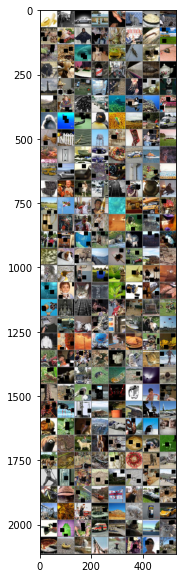

In [ ]:
image_loader.show(dataset_type='train')

#### Test Data

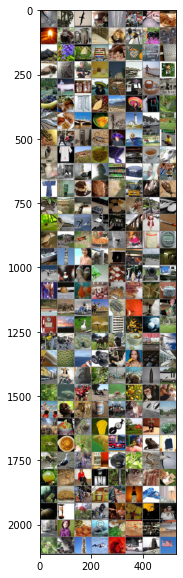

In [ ]:
image_loader.show(dataset_type='test')

## Model



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from cnn_models import ResNet18
from learner import Learner

In [ ]:
criterion = F.cross_entropy
cnn_learner = Learner(train_loader=image_loader.train_loader, test_loader=image_loader.test_loader, model=ResNet18(num_classes=200),loss_func=criterion)

### Model Summary

In [ ]:
cnn_learner.summary(input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## Finding the Learning rates

In [ ]:
import torch
import torch.optim as optim
from lr_finder import LRFinder

### lr_min

In [ ]:
# optimizer=optim.SGD(cnn_learner.model.parameters(), lr=1e-7, momentum=0.9, weight_decay=cnn_learner.weight_decay)
# lr_finder = LRFinder(cnn_learner.model, optimizer, criterion, device="cuda" )
# lr_finder.range_test(train_loader=image_loader.train_loader, val_loader=image_loader.test_loader, end_lr=3, num_iter=100)
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

### lr_max


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-02


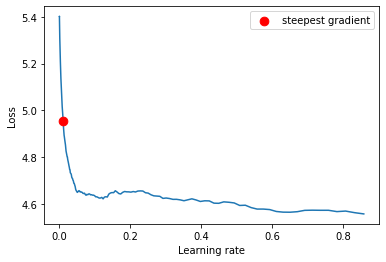

In [ ]:
optimizer=optim.SGD(cnn_learner.model.parameters(), lr=1e-4, momentum=0.9, weight_decay=cnn_learner.weight_decay)
lr_finder = LRFinder(cnn_learner.model, optimizer, criterion, device="cuda" )
lr_finder.range_test(image_loader.train_loader, end_lr=1, num_iter=300)
lr_finder.plot(log_lr=False)
lr_finder.reset()

## Training with ReduceLROnPlateau

We train the model for 30 epochs using `ReduceLROnPlateau`.
Eaxh epoch has 274 steps(iterations).
We used lr_min as `4E-03`.

In [ ]:
lr_max= 4E-02
lr_min = lr_max/10
optimizer=optim.SGD(cnn_learner.model.parameters(), lr=lr_max, momentum=0.9, weight_decay=cnn_learner.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=lr_min, eps=1e-08, verbose=False )

In [ ]:
cnn_learner.fit_custom(30,optimizer,lr_scheduler,pass_loss=True)

  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.126455783843994 Batch_id=273 Accuracy=6.39: 100%|██████████| 274/274 [04:59<00:00,  1.09s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 4.4790, Accuracy: 2311/30000 (7.70%)

EPOCH: 1


Loss=3.484531879425049 Batch_id=273 Accuracy=15.19: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.9382, Accuracy: 4391/30000 (14.64%)

EPOCH: 2


Loss=3.208165407180786 Batch_id=273 Accuracy=21.92: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.5092, Accuracy: 6392/30000 (21.31%)

EPOCH: 3


Loss=3.193148136138916 Batch_id=273 Accuracy=27.59: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.1343, Accuracy: 8094/30000 (26.98%)

EPOCH: 4


Loss=2.481854200363159 Batch_id=273 Accuracy=32.40: 100%|██████████| 274/274 [05:06<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.0244, Accuracy: 8814/30000 (29.38%)

EPOCH: 5


Loss=2.642591953277588 Batch_id=273 Accuracy=36.21: 100%|██████████| 274/274 [05:06<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 3.2624, Accuracy: 8254/30000 (27.51%)

EPOCH: 6


Loss=2.583542585372925 Batch_id=273 Accuracy=39.68: 100%|██████████| 274/274 [05:06<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.8893, Accuracy: 9782/30000 (32.61%)

EPOCH: 7


Loss=2.1511504650115967 Batch_id=273 Accuracy=42.68: 100%|██████████| 274/274 [05:06<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.6128, Accuracy: 11391/30000 (37.97%)

EPOCH: 8


Loss=2.2120015621185303 Batch_id=273 Accuracy=45.53: 100%|██████████| 274/274 [05:06<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.7726, Accuracy: 10575/30000 (35.25%)

EPOCH: 9


Loss=2.1832902431488037 Batch_id=273 Accuracy=48.18: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.4369, Accuracy: 12619/30000 (42.06%)

EPOCH: 10


Loss=1.9019745588302612 Batch_id=273 Accuracy=50.40: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.4563, Accuracy: 12329/30000 (41.10%)

EPOCH: 11


Loss=2.1474878787994385 Batch_id=273 Accuracy=53.04: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3172, Accuracy: 13236/30000 (44.12%)

EPOCH: 12


Loss=2.3480618000030518 Batch_id=273 Accuracy=55.26: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3636, Accuracy: 13268/30000 (44.23%)

EPOCH: 13


Loss=1.576658844947815 Batch_id=273 Accuracy=57.36: 100%|██████████| 274/274 [05:06<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2370, Accuracy: 14093/30000 (46.98%)

EPOCH: 14


Loss=1.6236422061920166 Batch_id=273 Accuracy=59.49: 100%|██████████| 274/274 [05:05<00:00,  1.11s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2789, Accuracy: 13908/30000 (46.36%)

EPOCH: 15


Loss=1.3937736749649048 Batch_id=273 Accuracy=61.60: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2377, Accuracy: 14358/30000 (47.86%)

EPOCH: 16


Loss=1.2759310007095337 Batch_id=273 Accuracy=63.57: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3576, Accuracy: 13833/30000 (46.11%)

EPOCH: 17


Loss=1.6865956783294678 Batch_id=273 Accuracy=65.78: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3305, Accuracy: 14163/30000 (47.21%)

EPOCH: 18


Loss=1.2291290760040283 Batch_id=273 Accuracy=67.52: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2742, Accuracy: 14370/30000 (47.90%)

EPOCH: 19


Loss=1.1821012496948242 Batch_id=273 Accuracy=69.71: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3102, Accuracy: 14588/30000 (48.63%)

EPOCH: 20


Loss=1.0094223022460938 Batch_id=273 Accuracy=71.83: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2438, Accuracy: 14872/30000 (49.57%)

EPOCH: 21


Loss=1.1548852920532227 Batch_id=273 Accuracy=73.77: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3558, Accuracy: 14713/30000 (49.04%)

EPOCH: 22


Loss=0.9375786781311035 Batch_id=273 Accuracy=75.81: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3324, Accuracy: 14918/30000 (49.73%)

EPOCH: 23


Loss=1.2486960887908936 Batch_id=273 Accuracy=77.67: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3712, Accuracy: 14955/30000 (49.85%)

EPOCH: 24


Loss=0.6841152310371399 Batch_id=273 Accuracy=79.62: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3930, Accuracy: 14925/30000 (49.75%)

EPOCH: 25


Loss=0.43007346987724304 Batch_id=273 Accuracy=89.75: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.0166, Accuracy: 16789/30000 (55.96%)

EPOCH: 26


Loss=0.36856648325920105 Batch_id=273 Accuracy=92.69: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.0155, Accuracy: 16843/30000 (56.14%)

EPOCH: 27


Loss=0.3080000877380371 Batch_id=273 Accuracy=93.58: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.0220, Accuracy: 16834/30000 (56.11%)

EPOCH: 28


Loss=0.383474737405777 Batch_id=273 Accuracy=94.28: 100%|██████████| 274/274 [05:05<00:00,  1.12s/it]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.0368, Accuracy: 16781/30000 (55.94%)

EPOCH: 29


Loss=0.26353543996810913 Batch_id=273 Accuracy=94.90: 100%|██████████| 274/274 [05:06<00:00,  1.12s/it]



Test set: Average loss: 2.0431, Accuracy: 16827/30000 (56.09%)



#### Plot Losses and Accuracy(Train and Test)

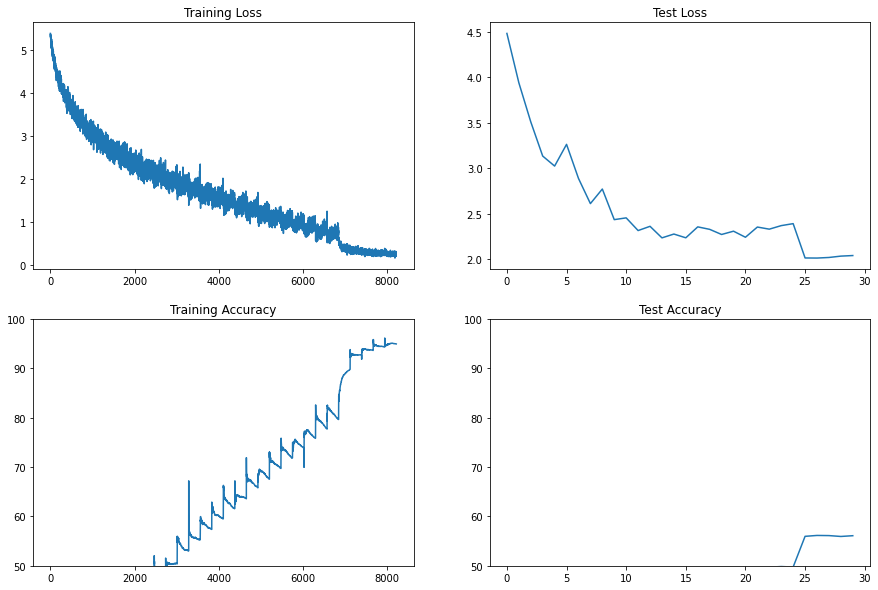

In [ ]:
cnn_learner.plot_losses()

## Interpreting the Learner on Test Data

In [ ]:
from interpreter import Interpreter

In [ ]:
intrepret = Interpreter(model=cnn_learner.model, dataloader=image_loader.test_loader, classes=image_loader.classes)

/content/TheSchoolOfAI-EVA5-Assignments/Assignment 11/src/interpreter.py:39: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idxs_mask = ((predicted == labels) == False).nonzero()


#### Performance Metrics
Here we see the Precision, Recall, F1-Score

In [ ]:
intrepret.show_classification_report()

,precision,recall,f1-score,support
n01443537,0.779874,0.794872,0.787302,156.0000
n01629819,0.759740,0.790541,0.774834,148.0000
n01641577,0.659574,0.567073,0.609836,164.0000
n01644900,0.345361,0.411043,0.375350,163.0000
n01698640,0.628788,0.553333,0.588652,150.0000
...,...,...,...,...
n09428293,0.453846,0.415493,0.433824,142.0000
n12267677,0.470588,0.500000,0.484848,144.0000
accuracy,0.560900,0.560900,0.560900,0.5609
macro avg,0.562703,0.560124,0.559977,30000.0000
